# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 28 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 28 ноября, -4 балла после 06:00 5 декабря, -6 баллов после 06:00 12 декабря, -8 баллов после 19 декабря

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import time

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

#%load_ext pycodestyle_magic

In [122]:
#%%pycodestyle


class MyKmeans: 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', batch_size=0):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter

        self.init = init
        self.batch_size = batch_size
        
    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        eps = 0.05
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        
        if self.init == 'random':
            self.centroids = X[np.random.choice(X.shape[0], size=self.k, replace=False)]
        if self.init == 'k-means':
            self.centroids[0] = X[np.random.choice(X.shape[0])]
            for i in range(1, self.k):
                dist = euclidean_distances(X, self.centroids[:i, :]).min(axis=1)
                dist = dist / dist.sum()
                self.centroids[i] = X[np.random.choice(X.shape[0],
                                                       p=dist, replace=False)]
        
        new_centroids = np.empty((self.k, X.shape[1]))
        n = X.shape[0]
        for i in range(self.max_iter):
            X_ = X
            if self.batch_size != 0:
                X_ = X[np.random.choice(n, replace=False,
                                        size=min(self.batch_size, n))]
            self.labels = euclidean_distances(X_, self.centroids).argmin(axis=1)
            for i in range(self.k):
                if np.any(self.labels == i, axis=0):
                    new_centroids[i] = np.mean(X_[self.labels == i], axis=0)
                else:
                    new_centroids[i] = X[np.random.choice(n)]
            if np.all(np.abs(new_centroids - self.centroids) < eps):
                break
            self.centroids = new_centroids

        self.labels = euclidean_distances(X, self.centroids).argmin(axis=1)
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        return euclidean_distances(X, self.centroids).argmin(axis=1)
        
class MiniBatchKMeans(MyKmeans):
    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', batch_size=10):
        super().__init__(k, metric, max_iter, random_state, init, batch_size)

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [123]:
from sklearn.datasets import make_blobs

In [124]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

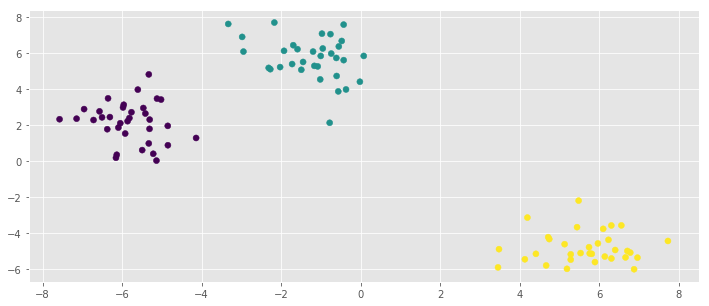

In [125]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

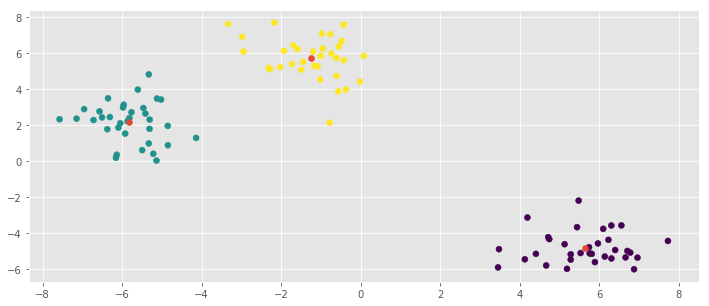

In [126]:
## Работоспособность MyKmeans
km = MyKmeans(k=3)
km.fit(X)
pred = km.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred)
plt.scatter(km.centroids[:, 0], km.centroids[:, 1])

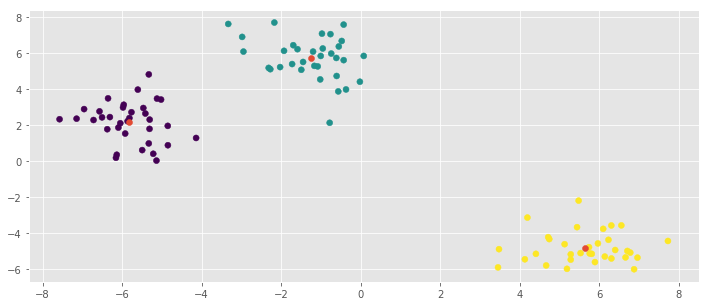

In [127]:
## Работоспособность MyKmeans++
kmpp = MyKmeans(k=3, init='k-means')
kmpp.fit(X)
pred = kmpp.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred)
plt.scatter(kmpp.centroids[:, 0], kmpp.centroids[:, 1])

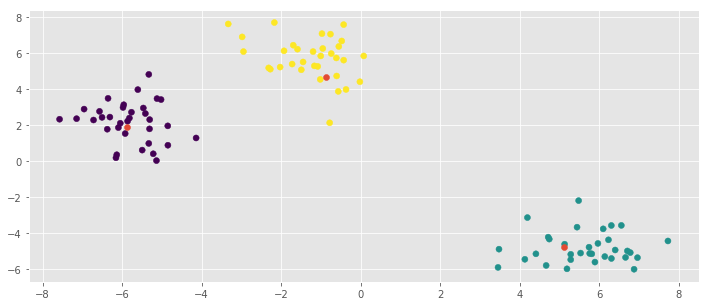

In [128]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
kmb = MiniBatchKMeans(k=3)
kmb.fit(X)
pred = kmb.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=pred)
plt.scatter(kmb.centroids[:, 0], kmb.centroids[:, 1])

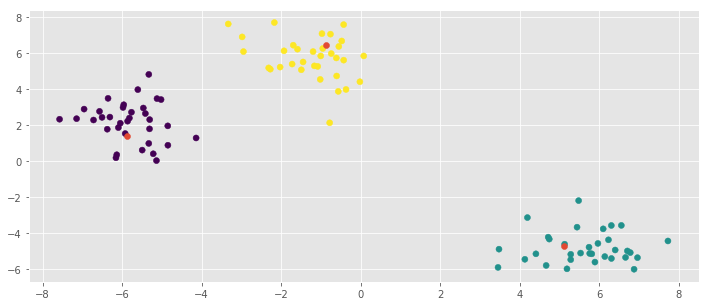

In [129]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
kmppb = MiniBatchKMeans(k=3, init='k-means')
kmppb.fit(X)
pred = kmppb.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=pred)
plt.scatter(kmb.centroids[:, 0], kmppb.centroids[:, 1])

In [130]:
## Время выполнения алгоритма Kmeans из sklearn
%time
km = KMeans(n_clusters=3, max_iter=1000)
km.fit(X)

Wall time: 0 ns


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [131]:
## Время выполнения алгоритма MyKmeans
km = MyKmeans(k=3)

%time
km.fit(X)
km.predict(X)

Wall time: 0 ns


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [132]:
## Время выполнения алгоритма MyKmeans++
kmpp = MyKmeans(k=3, init='k-means')

%time
kmpp.fit(X)
kmpp.predict(X)

Wall time: 0 ns


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [133]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
kmb = MiniBatchKMeans(k=3)

%time
kmb.fit(X)
kmb.predict(X)

Wall time: 0 ns


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [134]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
kmppb = MiniBatchKMeans(k=3, init='k-means')

%time
kmppb.fit(X)
kmppb.predict(X)

Wall time: 0 ns


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

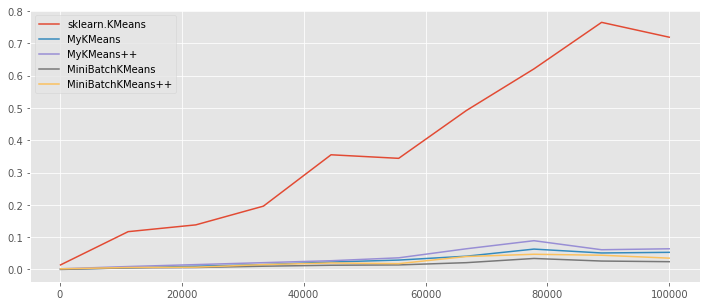

In [135]:
from time import time
samp = np.linspace(100, 100000, 10, dtype=int)
samp.shape[0]
alls = [KMeans(n_clusters=3),
        MyKmeans(k=3),
        MyKmeans(k=3, init='k-means'),
        MiniBatchKMeans(k=3),
        MiniBatchKMeans(k=3, init='k-means')]
labels = ['sklearn.KMeans', 'MyKMeans', 'MyKMeans++', 
             'MiniBatchKMeans', 'MiniBatchKMeans++']
t = np.zeros((len(alls), 10))
for i, j in enumerate(samp):
    X, y = make_blobs(n_samples=j, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    for k, m in enumerate(alls):
        t0 = time()
        m.fit(X)
        t[k][i] = time() - t0

for i, j in enumerate(alls):
    plt.plot(samp, t[i], label=labels[i])

plt.legend()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [136]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [137]:
df_sns.drop(['gradyear', 'gender', 'age', 'friends'], axis=1, inplace=True)
df_sns = (df_sns - df_sns.mean()) / df_sns.std()
df_sns.shape

(30000, 36)

In [138]:
X = df_sns.values
df_sns.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
1,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,1.067374,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
2,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,2.027874,-0.220399,-0.174905
3,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
4,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,2.273635,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,2.285084,2.719271


In [139]:
## MyKMeans
km = MyKmeans(k=9)
km.fit(X)
labels = km.labels
df_sns['cluster'] = labels
for cl in range(9):
    print(df_sns[df_sns['cluster'] == cl].mean().T.sort_values(ascending=False))
    print('=========================')

cheerleading    3.093734
kissed          2.842669
hair            2.276714
sex             2.184158
drugs           1.919729
drunk           1.510006
die             1.315668
clothes         1.232302
rock            1.118290
music           1.006677
death           0.865057
mall            0.804734
cute            0.770325
shopping        0.672686
football        0.666333
dress           0.636699
sports          0.564211
hot             0.513543
dance           0.480835
blonde          0.472061
hollister       0.371113
basketball      0.354395
god             0.347726
sexy            0.323792
abercrombie     0.300782
band            0.285224
church          0.268307
baseball        0.262194
swimming        0.260478
softball        0.178889
tennis          0.112176
soccer          0.106949
bible           0.106683
jesus           0.084380
volleyball      0.021410
cluster         0.000000
marching       -0.026147
dtype: float64
swimming        1.895169
cluster         1.000000
god       

In [140]:
## MyKMeans++
kmpp = MyKmeans(k=9, init='k-means')
kmpp.fit(X)
labels = kmpp.labels
df_sns['cluster'] = labels
for cl in range(9):
    print(df_sns[df_sns['cluster'] == cl].mean().T.sort_values(ascending=False))
    print('=========================')

cluster         0.000000
blonde         -0.027081
tennis         -0.031466
soccer         -0.044933
marching       -0.056761
baseball       -0.060304
volleyball     -0.062088
bible          -0.067316
sports         -0.081723
hot            -0.084803
sexy           -0.085787
football       -0.086846
death          -0.087029
basketball     -0.088616
band           -0.088664
dance          -0.091242
jesus          -0.092480
drunk          -0.098395
abercrombie    -0.099469
hollister      -0.100306
die            -0.101715
sex            -0.104284
rock           -0.106863
softball       -0.110124
god            -0.110575
music          -0.121984
drugs          -0.123205
cheerleading   -0.123502
mall           -0.127234
cute           -0.127837
shopping       -0.146990
dress          -0.148397
kissed         -0.148744
swimming       -0.156641
clothes        -0.166830
church         -0.188454
hair           -0.197375
dtype: float64
hair            1.631442
kissed          1.614229
clothes   

In [141]:
## MyKMeans с MiniBatchMyKMeans
kmb = MiniBatchKMeans(k=9)
kmb.fit(X)
labels = kmb.labels
df_sns['cluster'] = labels
for cl in range(9):
    print(df_sns[df_sns['cluster'] == cl].mean().T.sort_values(ascending=False))
    print('=========================')

hot             2.504571
dress           2.432918
death           1.881059
sexy            1.352705
jesus           1.092347
hair            0.392675
die             0.385498
clothes         0.296372
dance           0.294492
mall            0.266643
cute            0.239473
sex             0.214954
shopping        0.212612
god             0.195168
music           0.180534
kissed          0.155427
hollister       0.139483
rock            0.137917
drunk           0.116009
cheerleading    0.112175
abercrombie     0.096545
church          0.096508
bible           0.062229
swimming        0.042385
drugs           0.039694
blonde          0.023351
tennis          0.013260
basketball      0.003986
cluster         0.000000
volleyball     -0.004458
sports         -0.016350
soccer         -0.017830
baseball       -0.043642
football       -0.050850
band           -0.067172
softball       -0.068919
marching       -0.092556
dtype: float64
hollister       3.443571
hair            3.411562
abercrombi

In [142]:
## MyKMeans++ с MiniBatchMyKMeans
kmppb = MiniBatchKMeans(k=9, init='k-means')
kmppb.fit(X)
labels = kmppb.labels
df_sns['cluster'] = labels
for cl in range(9):
    print(df_sns[df_sns['cluster'] == cl].mean().T.sort_values(ascending=False))
    print('========================')

drugs           2.832117
die             1.774704
hair            1.014730
basketball      0.943253
cute            0.852416
drunk           0.701918
sex             0.612847
kissed          0.612437
music           0.571038
swimming        0.518623
shopping        0.497387
football        0.351170
mall            0.345436
clothes         0.246294
rock            0.232125
sports          0.228708
death           0.221559
dress           0.212389
abercrombie     0.206679
church          0.196073
band            0.163747
hot             0.128298
god             0.128284
soccer          0.117211
cheerleading    0.102600
hollister       0.099461
tennis          0.097263
blonde          0.073053
volleyball      0.063057
dance           0.040695
marching        0.038335
sexy            0.036634
jesus           0.034062
cluster         0.000000
bible          -0.031396
baseball       -0.034074
softball       -0.042737
dtype: float64
death           2.815564
cluster         1.000000
die       

## Вывод


MiniBatch как и ожидалось работает быстрее, но не так точно как без батчей

KMeans++ лучше обычного, потому что определяет центры кластеров не рандомно, в остальном такой же